In [74]:
import numpy as np
import scipy.stats as stats
import scipy.linalg as la
import matplotlib.pyplot as plt

In [24]:
"""
Generate M random walk traces of length K bounded in (0,1]

Inputs: 
M : number of traces
K : length of trace
p_init_i: vector of initial p values for each trace (M x 1)
volatility_param: Average step size at each time slot
bernoulli_param: Tradeoff between frequency of changes and step size for positive and negative steps

Outputs:
p_i_k : Matrix of probability traces (M x K)
"""
def generate_prob_traces(M, K, p_init_i, random_state, volatility_param, bernoulli_param=0.5, max_deviation_param = 0.25):
    # Each Bernoulli RV is mean-shited so that its expected value is zero
    bernoulli_rvs = volatility_param*(stats.bernoulli(p=bernoulli_param).rvs((M, K-1), random_state=random_state)-bernoulli_param)
    
    p_i_k = np.zeros((M, K))
    p_i_k[:, 0] = p_init_i
    for slot in range(K-1):
        p_i_k[:, slot+1] = p_i_k[:, slot] + bernoulli_rvs[:, slot]
    
        # Enforce upper and lower bounds
        upper_bound = np.where(p_i + max_deviation_param > 1, 1, p_i + max_deviation_param)
        lower_bound = np.where(p_i - max_deviation_param < volatility_param, volatility_param, p_i - max_deviation_param) # smallest value above zero
        p_i_k[:, slot+1] = np.where(p_i_k[:, slot+1] > upper_bound, upper_bound, p_i_k[:, slot+1])
        p_i_k[:, slot+1] = np.where(p_i_k[:, slot+1] < lower_bound, lower_bound, p_i_k[:, slot+1])

    return p_i_k

In [25]:
"""
Simulate the optimal stationary randomized policy

Inputs:
M : number of nodes
K : time horizon
alpha_i : per-node weight (M x 1)
q_i : per-node throughput constraint (M x 1)
p_i_k : per-node probability trace (M x K)
p_est_init_i : per-node initial probability estimate (M x 1)
G : number of simulations (output will be averaged over G)
K_opt : optimization horizon (how often the optimization is performed)
zeta : exponential moving average estimator weight

Outputs:
J_avg_exp : expected weighted sum AoI
x_max_norm : max normalized throughput debt
p_i_est_avg : per-node estimated probability trace (M x K)
"""

def sim_opt_stat_random_policy(M, K, alpha_i, q_i, p_i_k, p_est_init_i, G, K_opt, zeta, exact=False):
    J_avg_exp = 0
    x_max_norm = 0
    p_i_est_avg = np.zeros((M,K))

    # Repeat simulation over G samples
    for z in range(G):
        # Initialize transmission matrix
        d_i_k = np.zeros((M,K))
    
        # Initialize AoI and throughput debt vectors
        h_i = np.ones(M)
        x_i = np.zeros(M)
    
        # Generate outcome matrix that indicate whether transmission is successful in each time slot, assuming it is the selected time slot
        o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K), random_state=z+1000)

        # DEBUG:
        #J_avg_g = 0
    
        # Initialize estimates of p_i
        p_i_est = np.copy(p_est_init_i)
    
        # For each optimization horizon
        for opt_hor in range(int(K/K_opt)):
            # Throughput requirements for optimization
            tp_sum = np.sum(q_i/p_i_est)
            
            # Check whether q is a feasible set of minimum throughput requirements
            q_i_opt = q_i
            if tp_sum > 1.0:
                # Best we can do is solve the optimization problem with lower throughput requirements
                q_i_opt /= tp_sum
                #print(f"R* : TP Req Unfeasible {tp_sum}, opt no {opt_hor+1}")

            # Repeated calculation
            q_i_div_p_i = q_i_opt/p_i_est
            
            # Solve optimization
            gamma_i = alpha_i*p_i_est/(M*q_i_opt**2)
            gamma = gamma_test = np.max(gamma_i)
            sqrt = np.sqrt(gamma_i/gamma_test)
            mu_i = mu_i_test = q_i_div_p_i * np.where(sqrt > 1, sqrt, 1)
            S = S_test = np.sum(mu_i_test)
    
            # Get close to the optimal value through successive division by 2 (This significantly speeds up optimization)
            while S_test < 1.0:
                gamma = gamma_test
                mu_i = mu_i_test
                S = S_test
                
                gamma_test /= 2.0
                sqrt = np.sqrt(gamma_i/gamma_test)
                mu_i_test = q_i_div_p_i * np.where(sqrt > 1, sqrt, 1)
                S_test = np.sum(mu_i_test)

            # More exact optimization starting from value from previous loop
            step_size = 0.1
            while S < 1.0:
                S_prev = S
                gamma -= step_size
                sqrt = np.sqrt(gamma_i/gamma)
                mu_i = q_i_div_p_i * np.where(sqrt > 1, sqrt, 1)
                S = np.sum(mu_i)

                # Adjust step size dynamically if it is too small
                if np.abs(S-S_prev) < 0.001:
                    step_size *= 2
    
            # Ensure that mu_i exactly add up to one
            mu_i /= la.norm(mu_i, ord=1)
            
            # Sample to determine which nodes will be scheduled in which slot (for all the slots in the opt horizon)
            i_k = stats.rv_discrete(a=1, b=M, values=(i, mu_i)).rvs(size=K_opt, random_state=888*z+opt_hor)
    
            # Loop over slots
            for k in range(K_opt):
                # Calculate transmission matrix that indiciates which node has an arrival in this slot
                i_sel_idx = i_k[k]-1
                arrival_successful = o_i_k[i_sel_idx, k + opt_hor*K_opt]
                d_i_k[i_sel_idx, k + opt_hor*K_opt] = arrival_successful
    
                # Calculate weighted sum AoI
                J_avg_exp += np.sum(alpha_i * h_i)
                
                # Update AoI and throughput debt vectors
                h_i += 1
                if arrival_successful: # if transmission was successful
                    h_i[i_sel_idx] = 1
                x_i += q_i - d_i_k[:, k + opt_hor*K_opt]
    
                # Update estimate for the scheduled node
                if exact:
                    p_i_est = p_i_k[:, k + opt_hor*K_opt]
                else:
                    p_i_est[i_sel_idx] = zeta*arrival_successful + (1-zeta)*p_i_est[i_sel_idx]
                p_i_est_avg[:, k + opt_hor*K_opt] += p_i_est
    
        # Calculate max normalized throughput debt
        x_max_norm += np.max(np.where(x_i > 0, x_i, 0) / (K*q_i))
    
    J_avg_exp /= (G*K*M)
    x_max_norm /= G
    p_i_est_avg /= G

    return J_avg_exp, x_max_norm, p_i_est_avg

In [26]:
"""
Simulate the max-weight policy

Inputs:
M : number of nodes
K : time horizon
alpha_i : per-node weight (M x 1)
q_i : per-node throughput constraint (M x 1)
p_i_k : per-node probability trace (M x K)
p_est_init_i : per-source initial probability estimate (M x 1)
V : priority of throughput constraint in scheduling
G : number of simulations (output will be averaged over G)
zeta : exponential moving average estimator weight

Outputs:
J_avg_exp : expected weighted sum AoI
x_max_norm : max normalized throughput debt
p_i_est_avg : per-node estimated probability trace (M x K)
"""

def sim_max_weight_policy(M, K, alpha_i, q_i, p_i_k, p_est_init_i, V, G, zeta, exact=False):
    J_avg_exp = 0
    x_max_norm = 0
    p_i_est_avg = np.zeros((M,K))
    
    # Repeat simulation
    for z in range(G):
        # Initialize transmission matrix that indiciates which node has an arrival in which slot
        d_i_k = np.zeros((M,K))
        
        # Initialize AoI and throughput debt vectors
        h_i = np.ones(M)
        x_i = np.zeros(M)
    
        # Generate outcome matrix that indicates whether transmission is successful in each time slot, assuming it is the selected time slot
        o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K), random_state=z+2000)

        # DEBUG:
        #J_avg_g = 0
    
        # Initialize estimates of p_i
        p_i_est = np.copy(p_est_init_i)
        
        # Loop over slots
        for k in range(K):
            # Select node according to policy
            W_i = (0.5*alpha_i*(h_i**2+2*h_i) + V*np.where(x_i > 0, x_i, 0))*p_i_est
            i_sel_idx = np.argmax(W_i)
            
            # Update transmission matrix based on whether transmission was successful or not
            arrival_successful = o_i_k[i_sel_idx, k]
            d_i_k[i_sel_idx, k] = arrival_successful
    
            # Calculate weighted sum AoI
            J_avg_exp += np.sum(alpha_i * h_i)
            #J_avg_g += np.sum(alpha_i * h_i)
            
            # Update AoI and throughput debt vectors
            h_i += 1
            if arrival_successful: # if transmission was successful
                h_i[i_sel_idx] = 1
            x_i += q_i - d_i_k[:, k]
    
            # Update estimate for the scheduled node
            if exact:
                p_i_est = p_i_k[:, k]
            else:
                p_i_est[i_sel_idx] = zeta*arrival_successful + (1-zeta)*p_i_est[i_sel_idx]
            p_i_est_avg[:, k] += p_i_est
    
        # Calculate max normalized throughput debt
        x_max_norm += np.max(np.where(x_i > 0, x_i, 0) / (K*q_i))
        #print(J_avg_g/(K*M))
        
    J_avg_exp /= (G*K*M)
    x_max_norm /= G
    p_i_est_avg /= G

    return J_avg_exp, x_max_norm, p_i_est_avg

In [5]:
"""
Simulate the drift-plus-penalty policy

Inputs:
M : number of node
K : time horizon
alpha_i : per-node weight (M x 1)
q_i : per-node throughput constraint (M x 1)
p_i_k : per-node probability trace (M x K)
p_est_init_i : per-node initial probability estimate (M x 1)
V_prime : priority of throughput constraint in scheduling
G : number of simulations (output will be averaged over G)
K_opt : optimization horizon (how often the optimization is performed)
zeta : exponential moving average estimator weight

Outputs:
J_avg_exp : expected weighted sum AoI
x_max_norm : max normalized throughput debt
p_i_est_avg : per-node estimated probability trace (M x K)
"""

def sim_drift_plus_penalty(M, K, alpha_i, q_i, p_i_k, p_est_init_i, V_prime, G, K_opt, zeta, exact=False):
    J_avg_exp = 0
    x_max_norm = 0
    p_i_est_avg = np.zeros((M,K))
    
    # Repeat simulation
    for z in range(G):
        # Initialize transmission matrix that indiciates which node has an arrival in which slot
        d_i_k = np.zeros((M,K))
        
        # Initialize AoI and throughput debt vectors
        h_i = np.ones(M)
        x_i = np.zeros(M)
        x_i_opt = np.zeros(M)
    
        # Generate outcome matrix that indicates whether transmission is successful in each time slot, assuming it is the selected time slot
        o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K), random_state=z+3000)

        # DEBUG:
        #J_avg_g = 0
    
        # Initialize estimates of p_i
        p_i_est = np.copy(p_est_init_i)
    
        # For each optimization horizon
        for opt_hor in range(int(K/K_opt)):
            # Throughput requirements for optimization
            tp_sum = np.sum(q_i/p_i_est)
            
            # Check whether q is a feasible set of minimum throughput requirements
            q_i_opt = q_i
            if tp_sum > 1.0:
                # Best we can do is solve the optimization problem with lower throughput requirements
                q_i_opt /= tp_sum
                
                #print(f"DPP: TP Req Unfeasible {tp_sum}, opt no {opt_hor+1}")
            
            # Repeated calculation
            q_i_div_p_i = q_i_opt/p_i_est
            
            # Solve optimization
            gamma_i = alpha_i*p_i_est/(M*q_i_opt**2)
            gamma = gamma_test = np.max(gamma_i)
            sqrt = np.sqrt(gamma_i/gamma_test)
            mu_i = mu_i_test = q_i_div_p_i * np.where(sqrt > 1, sqrt, 1)
            S = S_test = np.sum(mu_i_test)
    
            # Get close to the optimal value through successive division by 2 (This significantly speeds up optimization)
            while S_test < 1.0:
                gamma = gamma_test
                mu_i = mu_i_test
                S = S_test
                
                gamma_test /= 2.0
                sqrt = np.sqrt(gamma_i/gamma_test)
                mu_i_test = q_i_div_p_i * np.where(sqrt > 1, sqrt, 1)
                S_test = np.sum(mu_i_test)

            # More exact optimization starting from value from previous loop
            step_size = 0.1
            while S < 1.0:
                S_prev = S
                gamma -= step_size
                sqrt = np.sqrt(gamma_i/gamma)
                mu_i = q_i_div_p_i * np.where(sqrt > 1, sqrt, 1)
                S = np.sum(mu_i)

                # Adjust step size dynamically if it is too small
                if np.abs(S-S_prev) < 0.001:
                    step_size *= 2
    
            # Ensure that mu_i exactly add up to one
            mu_i /= la.norm(mu_i, ord=1)
            
            # Loop over slots
            for k in range(K_opt):
                # Select node according to policy
                W_prime_i = (0.5)*alpha_i/mu_i*h_i + V_prime*p_i_est*np.where(x_i_opt > 0, x_i_opt, 0)
                i_sel_idx = np.argmax(W_prime_i)
                
                # Update transmission matrix based on whether transmission was successful or not
                arrival_successful = o_i_k[i_sel_idx, k + opt_hor*K_opt]
                d_i_k[i_sel_idx, k + opt_hor*K_opt] = arrival_successful
    
                # Calculate weighted sum AoI
                J_avg_exp += np.sum(alpha_i * h_i)
                #J_avg_g += np.sum(alpha_i * h_i)
                
                # Update AoI and throughput debt vectors
                h_i += 1
                if arrival_successful: # if transmission was successful
                    h_i[i_sel_idx] = 1
                x_i += q_i - d_i_k[:, k + opt_hor*K_opt]
                x_i_opt += q_i_opt - d_i_k[:, k + opt_hor*K_opt]
        
                # Update estimate for the scheduled node
                if exact:
                    p_i_est = p_i_k[:, k + opt_hor*K_opt]
                else:
                    p_i_est[i_sel_idx] = zeta*arrival_successful + (1-zeta)*p_i_est[i_sel_idx]
                p_i_est_avg[:, k + opt_hor*K_opt] += p_i_est
    
        # Calculate max normalized throughput debt
        x_max_norm += np.max(np.where(x_i > 0, x_i, 0) / (K*q_i))
        #print(J_avg_g/(K*M))
        
    J_avg_exp /= (G*K*M)
    x_max_norm /= G
    p_i_est_avg /= G

    return J_avg_exp, x_max_norm, p_i_est_avg

In [6]:
"""
Simulate the Whittle's index policy with throughput constraints

Inputs:
M : number of node
K : time horizon
alpha_i : per-node weight (M x 1)
q_i : per-node throughput constraint (M x 1)
p_i_k : per-node probability trace (M x K)
p_est_init_i : per-node initial probability estimate (M x 1)
G : number of simulations (output will be averaged over G)
K_opt : optimization horizon (how often the optimization is performed)
zeta : exponential moving average estimator weight

Outputs:
J_avg_exp : expected weighted sum AoI
x_max_norm : max normalized throughput debt
p_i_est_avg : per-node estimated probability trace (M x K)
"""

def sim_whittle_index_policy_with_tp_con(M, K, alpha_i, q_i, p_i_k, p_est_init_i, G, K_opt, zeta, exact=False):
    J_avg_exp = 0
    x_max_norm = 0
    p_i_est_avg = np.zeros((M,K))
    
    # Repeat simulation
    for z in range(G):
        # Initialize transmission matrix that indiciates which node has an arrival in which slot
        d_i_k = np.zeros((M,K))
        
        # Initialize AoI and throughput debt vectors
        h_i = np.ones(M)
        x_i = np.zeros(M)
    
        # Generate outcome matrix that indicates whether transmission is successful in each time slot, assuming it is the selected time slot
        o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K), random_state=z+4000)
    
        # Initialize estimates of p_i
        p_i_est = np.copy(p_est_init_i)
    
        # For each optimization horizon
        for opt_hor in range(int(K/K_opt)):
            # Throughput requirements for optimization
            tp_sum = np.sum(q_i/p_i_est)
            
            # Check whether q is a feasible set of minimum throughput requirements
            q_i_opt = q_i
            if tp_sum > 1.0:
                # If not, best we can do is solve the optimization problem with lower throughput requirements
                q_i_opt /= tp_sum
                #print(f"WI: TP Req Unfeasible {tp_sum}, opt no {opt_hor+1}")
    
            # Solve optimization
            chi_i = alpha_i*p_i_est*((1/q_i_opt)**2 - (1/p_i_est - 1/2)**2)/2
            C = C_test = np.max(chi_i)
            phi_i_inv = phi_i_inv_test = p_i_est*np.sqrt(2*np.where(chi_i < C_test, chi_i, C_test) / (alpha_i*p_i_est) + (1/p_i_est - 1/2)**2)
            S = S_test = np.sum(1/phi_i_inv_test)
    
            while S_test < 1.0:
                C = C_test
                phi_i_inv = phi_i_inv_test
                S = S_test
    
                C_test /= 2.0
                phi_i_inv_test = p_i_est*np.sqrt(2*np.where(chi_i < C_test, chi_i, C_test) / (alpha_i*p_i_est) + (1/p_i_est - 1/2)**2)
                S_test = np.sum(1/phi_i_inv_test)
            
            # More exact optimization starting from value from previous loop
            step_size = 0.1
            while S < 1.0:
                S_prev = S
                C -= step_size
                phi_i_inv = p_i_est*np.sqrt(2*np.where(chi_i < C, chi_i, C) / (alpha_i*p_i_est) + (1/p_i_est - 1/2)**2)
                S = np.sum(1/phi_i_inv)
                
                # Adjust step size dynamically if it is too small
                if np.abs(S-S_prev) < 0.001:
                    step_size *= 2
                
            C_star = C
            chi_i_star = np.where(chi_i < C_star, chi_i, C_star)
            theta_i = C_star - chi_i_star
            
            # Loop over slots
            for k in range(K_opt):
                # Select node according to policy
                C_i_h_i = 0.5*alpha_i*p_i_est*(h_i**2 + (2/p_i_est)*h_i - h_i) + theta_i
                i_sel_idx = np.argmax(C_i_h_i)
                
                # Update transmission matrix based on whether transmission was successful or not
                arrival_successful = o_i_k[i_sel_idx, k + opt_hor*K_opt]
                d_i_k[i_sel_idx, k + opt_hor*K_opt] = arrival_successful
    
                # Calculate weighted sum AoI
                J_avg_exp += np.sum(alpha_i * h_i)
                
                # Update AoI and throughput debt vectors
                h_i += 1
                if arrival_successful: # if transmission was successful
                    h_i[i_sel_idx] = 1
                x_i += q_i - d_i_k[:, k + opt_hor*K_opt]
    
                # Update estimate for the scheduled node
                if exact:
                    p_i_est = p_i_k[:, k + opt_hor*K_opt]
                else:
                    p_i_est[i_sel_idx] = zeta*arrival_successful + (1-zeta)*p_i_est[i_sel_idx]
                p_i_est_avg[:, k + opt_hor*K_opt] += p_i_est
    
        # Calculate max normalized throughput debt
        x_max_norm += np.max(np.where(x_i > 0, x_i, 0) / (K*q_i))
        
    J_avg_exp /= (G*K*M)
    x_max_norm /= G
    p_i_est_avg /= G

    return J_avg_exp, x_max_norm, p_i_est_avg

In [7]:
"""
Simulate the maximum weighted average policy

Inputs:
M : number of node
K : time horizon
alpha_i : per-node weight (M x 1)
q_i : per-node throughput constraint (M x 1)
p_i_k : per-node probability trace (M x K)
G : number of simulations (output will be averaged over G)

Outputs:
J_avg_exp : expected weighted sum AoI
x_max_norm : max normalized throughput debt
"""

def sim_max_weighted_average_policy(M, K, alpha_i, q_i, p_i_k, G):
    J_avg_exp = 0
    x_max_norm = 0

    # Repeat simulation
    for z in range(G):
        # Initialize transmission matrix that indiciates which node has an arrival in which slot
        d_i_k = np.zeros((M,K))
        
        # Initialize AoI and throughput debt vectors
        h_i = np.ones(M)
        x_i = np.zeros(M)
    
        # Generate outcome matrix that indicates whether transmission is successful in each time slot, assuming it is the selected time slot
        o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K), random_state=z+5000)

        # Loop over slots
        for k in range(K):
            # Select node according to policy
            i_sel_idx = np.argmax(alpha_i * h_i)
            
            # Update transmission matrix based on whether transmission was successful or not
            arrival_successful = o_i_k[i_sel_idx, k]
            d_i_k[i_sel_idx, k] = arrival_successful
    
            # Calculate weighted sum AoI
            J_avg_exp += np.sum(alpha_i * h_i)
            
            # Update AoI and throughput debt vectors
            h_i += 1
            if arrival_successful: # if transmission was successful
                h_i[i_sel_idx] = 1
            x_i += q_i - d_i_k[:, k]
    
        # Calculate max normalized throughput debt
        x_max_norm += np.max(np.where(x_i > 0, x_i, 0) / (K*q_i))
        #print(J_avg_g/(K*M))
        
    J_avg_exp /= (G*K*M)
    x_max_norm /= G

    return J_avg_exp, x_max_norm

In [8]:
"""
Simulate the Whittle's index policy without throughput constraints

Inputs:
M : number of nodes
K : time horizon
alpha_i : per-node weight (M x 1)
q_i : per-node throughput constraint (M x 1)
p_i_k : per-node probability trace (M x K)
p_est_init_i : per-source initial probability estimate (M x 1)
G : number of simulations (output will be averaged over G)
zeta : exponential moving average estimator weight

Outputs:
J_avg_exp : expected weighted sum AoI
x_max_norm : max normalized throughput debt
p_i_est_avg : per-node estimated probability trace (M x K)
"""

def sim_whittle_index_policy_without_tp_con(M, K, alpha_i, q_i, p_i_k, p_est_init_i, G, zeta, exact=False):
    J_avg_exp = 0
    x_max_norm = 0
    p_i_est_avg = np.zeros((M,K))
    
    # Repeat simulation
    for z in range(G):
        # Initialize transmission matrix that indiciates which node has an arrival in which slot
        d_i_k = np.zeros((M,K))
        
        # Initialize AoI and throughput debt vectors
        h_i = np.ones(M)
        x_i = np.zeros(M)
    
        # Generate outcome matrix that indicates whether transmission is successful in each time slot, assuming it is the selected time slot
        o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K), random_state=z+6000)
    
        # Initialize estimates of p_i
        p_i_est = np.copy(p_est_init_i)
        
        # Loop over slots
        for k in range(K):
            # Select node according to policy
            C_i_h_i = 0.5*alpha_i*p_i_est*(h_i**2 + (2/p_i_est)*h_i - h_i)
            i_sel_idx = np.argmax(C_i_h_i)
            
            # Update transmission matrix based on whether transmission was successful or not
            arrival_successful = o_i_k[i_sel_idx, k]
            d_i_k[i_sel_idx, k] = arrival_successful
    
            # Calculate weighted sum AoI
            J_avg_exp += np.sum(alpha_i * h_i)
            
            # Update AoI and throughput debt vectors
            h_i += 1
            if arrival_successful: # if transmission was successful
                h_i[i_sel_idx] = 1
            x_i += q_i - d_i_k[:, k]
    
            # Update estimate for the scheduled node
            if exact:
                p_i_est = p_i_k[:, k]
            else:
                p_i_est[i_sel_idx] = zeta*arrival_successful + (1-zeta)*p_i_est[i_sel_idx]
            p_i_est_avg[:, k] += p_i_est
    
        # Calculate max normalized throughput debt
        x_max_norm += np.max(np.where(x_i > 0, x_i, 0) / (K*q_i))
        
    J_avg_exp /= (G*K*M)
    x_max_norm /= G
    p_i_est_avg /= G

    return J_avg_exp, x_max_norm, p_i_est_avg

In [9]:
"""
Simulate the largest weighted debt first policy

Inputs:
M : number of nodes
K : time horizon
alpha_i : per-node weight (M x 1)
q_i : per-node throughput constraint (M x 1)
p_i_k : per-node probability trace (M x K)
p_est_init_i : per-source initial probability estimate (M x 1)
G : number of simulations (output will be averaged over G)
zeta : exponential moving average estimator weight

Outputs:
J_avg_exp : expected weighted sum AoI
x_max_norm : max normalized throughput debt
p_i_est_avg : per-node estimated probability trace (M x K)
"""

def sim_largest_weighted_debt_first_policy(M, K, alpha_i, q_i, p_i_k, p_est_init_i, G, zeta, exact=False):
    J_avg_exp = 0
    x_max_norm = 0
    p_i_est_avg = np.zeros((M,K))
    
    # Repeat simulation
    for z in range(G):
        # Initialize transmission matrix that indiciates which node has an arrival in which slot
        d_i_k = np.zeros((M,K))
        
        # Initialize AoI and throughput debt vectors
        h_i = np.ones(M)
        x_i = np.zeros(M)
    
        # Generate outcome matrix that indicates whether transmission is successful in each time slot, assuming it is the selected time slot
        o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K), random_state=z+7000)
    
        # Initialize estimates of p_i
        p_i_est = np.copy(p_est_init_i)
        
        # Loop over slots
        for k in range(K):
            # Select node according to policy
            i_sel_idx = np.argmax(x_i/p_i_est)
            
            # Update transmission matrix based on whether transmission was successful or not
            arrival_successful = o_i_k[i_sel_idx, k]
            d_i_k[i_sel_idx, k] = arrival_successful
    
            # Calculate weighted sum AoI
            J_avg_exp += np.sum(alpha_i * h_i)
            
            # Update AoI and throughput debt vectors
            h_i += 1
            if arrival_successful: # if transmission was successful
                h_i[i_sel_idx] = 1
            x_i += q_i - d_i_k[:, k]
    
            # Update estimate for the scheduled node
            if exact:
                p_i_est = p_i_k[:, k]
            else:
                p_i_est[i_sel_idx] = zeta*arrival_successful + (1-zeta)*p_i_est[i_sel_idx]
            p_i_est_avg[:, k] += p_i_est
    
        # Calculate max normalized throughput debt
        x_max_norm += np.max(np.where(x_i > 0, x_i, 0) / (K*q_i))
        
    J_avg_exp /= (G*K*M)
    x_max_norm /= G
    p_i_est_avg /= G

    return J_avg_exp, x_max_norm, p_i_est_avg

In [ ]:
policy = "mw"

H = 10
G = 10

# Constant parameters
epsilon = 0.9  # Must be [0, 1)
K_opt = 500
zeta = 0.05

# Varying parameters
volatilities = np.array([0])#np.array([0, 0.005, 0.01, 0.02])
M_values = np.arange(5, 31, 5)
K_values = M_values * 10**4
V_values = V_prime_values = M_values**2

J_avg_exp_values = np.zeros((len(volatilities),6))
x_max_norm_values = np.zeros((len(volatilities),6))

# Run sims across number of nodes
for vol in range(len(volatilities)):
    volatility_param = volatilities[vol]
    print(f"starting sims for volatility {volatility_param}")
    for j in range(6):
        M = M_values[j]
        K = K_values[j]
        V = V_values[j]
        V_prime = V_prime_values[j]
    
        # Set per-node parameters
        i = np.arange(start=1, stop=M+1)
        alpha_i = (M + 1 - i)/M
        p_i = i/M # Initial values for both the probability traces and the probability estimates
        # (Assumption that we are making is that the scheduler knows this information about the channel. This is to ensure consistency with the Kadota paper)
        q_i = epsilon*p_i/M
    
        print(f"starting sims for {M} nodes")
        
        # Run sims H*G times
        for z in range(H):
            # Generate probability traces
            if volatility_param != 0:
                p_i_k = generate_prob_traces(M, K, p_i, z+100*vol, volatility_param)
            else:
                p_i_k = np.repeat(np.reshape(p_i, (M,1)), K, axis=1)

            if policy == "r_star":
                J_avg_exp, x_max_norm, _ = sim_opt_stat_random_policy(M, K, alpha_i, q_i, p_i_k, p_i, G, K_opt, zeta, exact=False)
            elif policy == "mw":
                J_avg_exp, x_max_norm, _ = sim_max_weight_policy(M, K, alpha_i, q_i, p_i_k, p_i, V, G, zeta, exact=False)
            elif policy == "dpp":
                J_avg_exp, x_max_norm, _ = sim_drift_plus_penalty(M, K, alpha_i, q_i, p_i_k, p_i, V_prime, G, K_opt, zeta, exact=False)
            elif policy == "wi":
                J_avg_exp, x_max_norm, _ = sim_whittle_index_policy_with_tp_con(M, K, alpha_i, q_i, p_i_k, p_i, G, K_opt, zeta, exact=False)
            elif policy == "mwa":
                J_avg_exp, x_max_norm, _ = sim_max_weighted_average_policy(M, K, alpha_i, q_i, p_i_k, G)
            elif policy == "wp":
                J_avg_exp, x_max_norm, _ = sim_whittle_index_policy_without_tp_con(M, K, alpha_i, q_i, p_i_k, p_i, G, zeta, exact=False)
            elif policy == "ld":
                J_avg_exp, x_max_norm, _ = sim_largest_weighted_debt_first_policy(M, K, alpha_i, q_i, p_i_k, p_i, G, zeta, exact=False)
            print(J_avg_exp)
    
            J_avg_exp_values[vol,j] += J_avg_exp
            x_max_norm_values[vol,j] += x_max_norm
    
            print(f"finished iteration {z+1} of {H}")
        
    J_avg_exp_values[vol,:] /= H
    x_max_norm_values[vol,:] /= H

starting sims for volatility 0
starting sims for 5 nodes
4.8704199200006695
finished iteration 1 of 10
4.8704199200006695
finished iteration 2 of 10
4.8704199200006695
finished iteration 3 of 10
4.8704199200006695
finished iteration 4 of 10
4.8704199200006695
finished iteration 5 of 10
4.8704199200006695
finished iteration 6 of 10
4.8704199200006695
finished iteration 7 of 10
4.8704199200006695
finished iteration 8 of 10
4.8704199200006695
finished iteration 9 of 10
4.8704199200006695
finished iteration 10 of 10
starting sims for 10 nodes
11.027716429999264
finished iteration 1 of 10
11.027716429999264
finished iteration 2 of 10
11.027716429999264
finished iteration 3 of 10
11.027716429999264
finished iteration 4 of 10
11.027716429999264
finished iteration 5 of 10
11.027716429999264
finished iteration 6 of 10
11.027716429999264
finished iteration 7 of 10
11.027716429999264
finished iteration 8 of 10
11.027716429999264
finished iteration 9 of 10
11.027716429999264
finished iteration 10 

In [67]:
np.save("mw_J_avg_exp_values", J_avg_exp_values)
np.save("mw_x_max_norm_values", x_max_norm_values)

Text(0, 0.5, 'Expected Weighted Sum AoI')

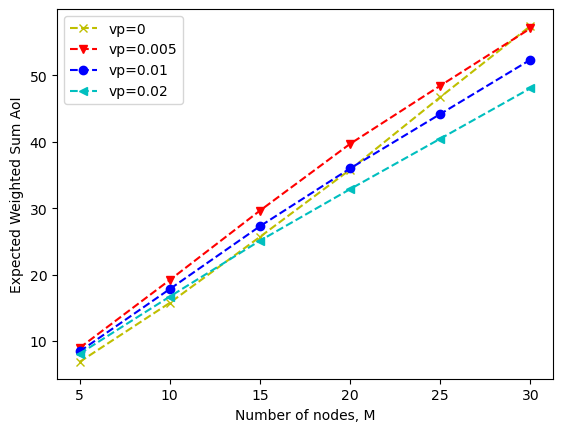

In [76]:
plt.figure()
plt.plot(M_values, r_star_J_avg_exp_values[0,:], color='y', linestyle='dashed', label='vp=0', marker="x")
plt.plot(M_values, r_star_J_avg_exp_values[1,:], color='r', linestyle='dashed', label='vp=0.005', marker="v")
plt.plot(M_values, r_star_J_avg_exp_values[2,:], color='b', linestyle='dashed', label='vp=0.01', marker="o")
plt.plot(M_values, r_star_J_avg_exp_values[3,:], color='c', linestyle='dashed', label='vp=0.02', marker="<")
plt.legend()
plt.xlabel("Number of nodes, M")
plt.ylabel("Expected Weighted Sum AoI")

Text(0, 0.5, 'Expected Weighted Sum AoI')

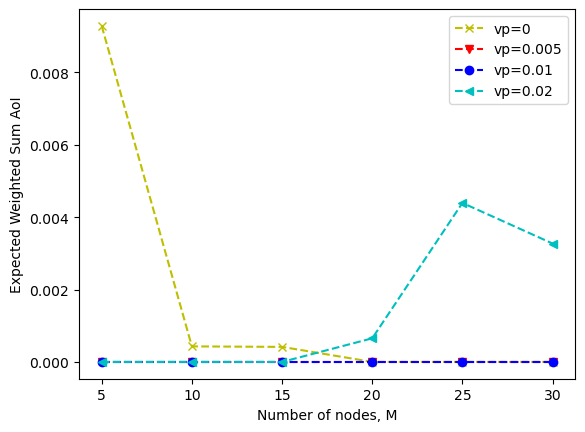

In [75]:
plt.figure()
plt.plot(M_values, r_star_x_max_norm_values[0,:], color='y', linestyle='dashed', label='vp=0', marker="x")
plt.plot(M_values, r_star_x_max_norm_values[1,:], color='r', linestyle='dashed', label='vp=0.005', marker="v")
plt.plot(M_values, r_star_x_max_norm_values[2,:], color='b', linestyle='dashed', label='vp=0.01', marker="o")
plt.plot(M_values, r_star_x_max_norm_values[3,:], color='c', linestyle='dashed', label='vp=0.02', marker="<")
plt.legend()
plt.xlabel("Number of nodes, M")
plt.ylabel("Expected Weighted Sum AoI")

In [ ]:
plt.figure()
plt.plot(M_values, r_star_J_avg_exp_values, color='r', linestyle='dashed', label='R*', marker="v")
plt.plot(M_values, mw_J_avg_exp_values, color='b', linestyle='dashed', label='MW', marker="o")
plt.plot(M_values, dpp_J_avg_exp_values, color='c', linestyle='dashed', label='DPP', marker="<")
plt.plot(M_values, wi_J_avg_exp_values, color='k', linestyle='dashed', label='WI w/ TP', marker="^")
plt.plot(M_values, mwa_J_avg_exp_values, color='y', linestyle='dashed', label='MWA', marker="d")
plt.plot(M_values, wp_J_avg_exp_values, color='g', linestyle='dashed', label='WI w/o TP', marker="x")
plt.plot(M_values, ld_J_avg_exp_values, color='m', linestyle='dashed', label='LD', marker="+")
plt.legend()
plt.xlabel("Number of nodes, M")
plt.ylabel("Expected Weighted Sum AoI")

In [ ]:
plt.figure()
plt.plot(M_values, r_star_x_max_norm_values, color='r', linestyle='dashed', label='R*', marker="v")
plt.plot(M_values, mw_x_max_norm_values, color='b', linestyle='dashed', label='MW', marker="o")
plt.plot(M_values, dpp_x_max_norm_values, color='c', linestyle='dashed', label='DPP', marker="<")
plt.plot(M_values, wi_x_max_norm_values, color='k', linestyle='dashed', label='WI w/ TP', marker="^")
plt.plot(M_values, mwa_x_max_norm_values, color='y', linestyle='dashed', label='MWA', marker="d")
plt.plot(M_values, wp_x_max_norm_values, color='g', linestyle='dashed', label='WI w/o TP', marker="x")
plt.plot(M_values, ld_x_max_norm_values, color='m', linestyle='dashed', label='LD', marker="+")
plt.legend()
plt.xlabel("Number of nodes, M")
plt.ylabel("Max Normalized Throughput Debt")

In [ ]:
p_i_k = generate_prob_traces(M, K, p_i, 0.0025)
for src in range(M):
    plt.figure()
    plt.plot(np.arange(1,K+1), p_i_k[src, :])
    plt.ylim([0,1])
    plt.title(f"Node {src+1} of {M}")
    plt.ylabel("Prob. of Successful Transmission")
    plt.xlabel("time")

In [ ]:
for src in range(M):
    plt.figure()
    plt.plot(np.arange(1,K+1), p_i_k[src, :], label="Actual")
    plt.plot(np.arange(1,K+1), p_i_est_avg[src, :], alpha=0.7, label="Estimate")
    plt.ylim([0,1])
    plt.title(f"Node {src+1} of {M}")
    plt.ylabel("Prob. of Successful Transmission")
    plt.xlabel("time")
    plt.legend()

LD, MW, and DPP are the only policies that explicitly consider throughput debt. Both MW and DPP also consider AoI. However, with MW, the weight is quadratic with respect to AoI, while with DPP, the weight is linear with respect to AoI. LD does not consider AoI at all. Hence, it could be concluded that LD and DPP put too much importance on throughput debt, and not enough on AoI. While performance under static network conditions is comparable between MW and DPP, the advantage of MW is revealed under stochastic, unknown network conditions.